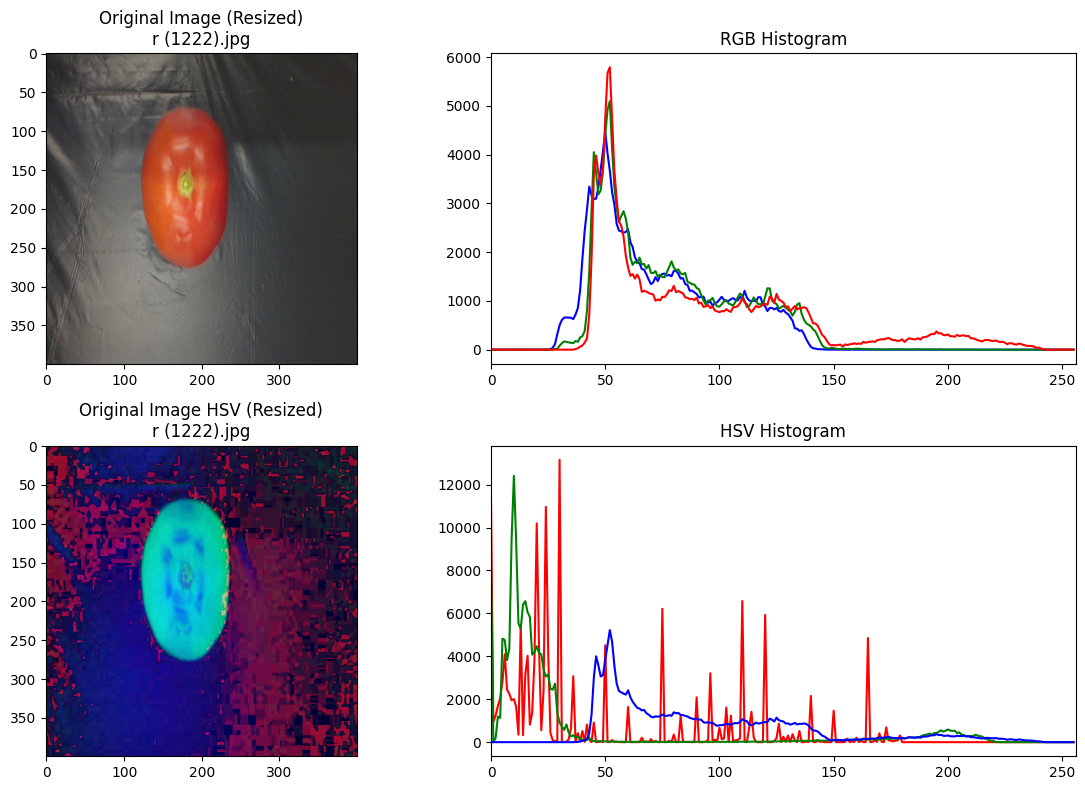

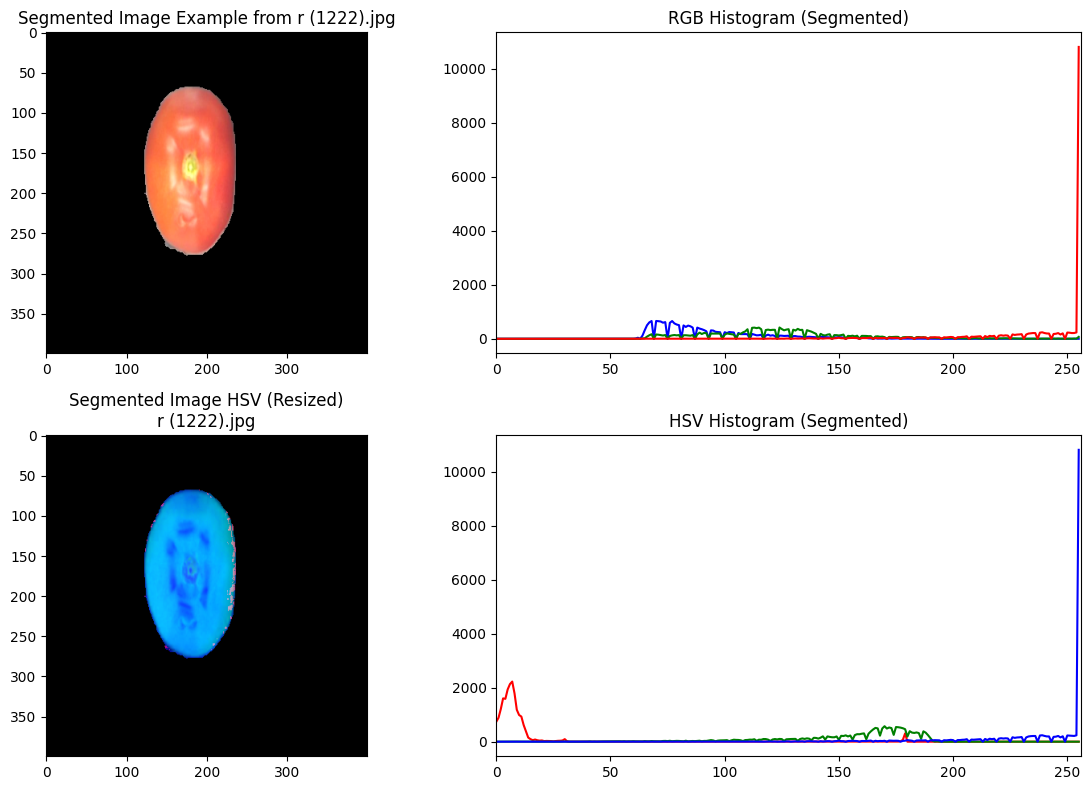

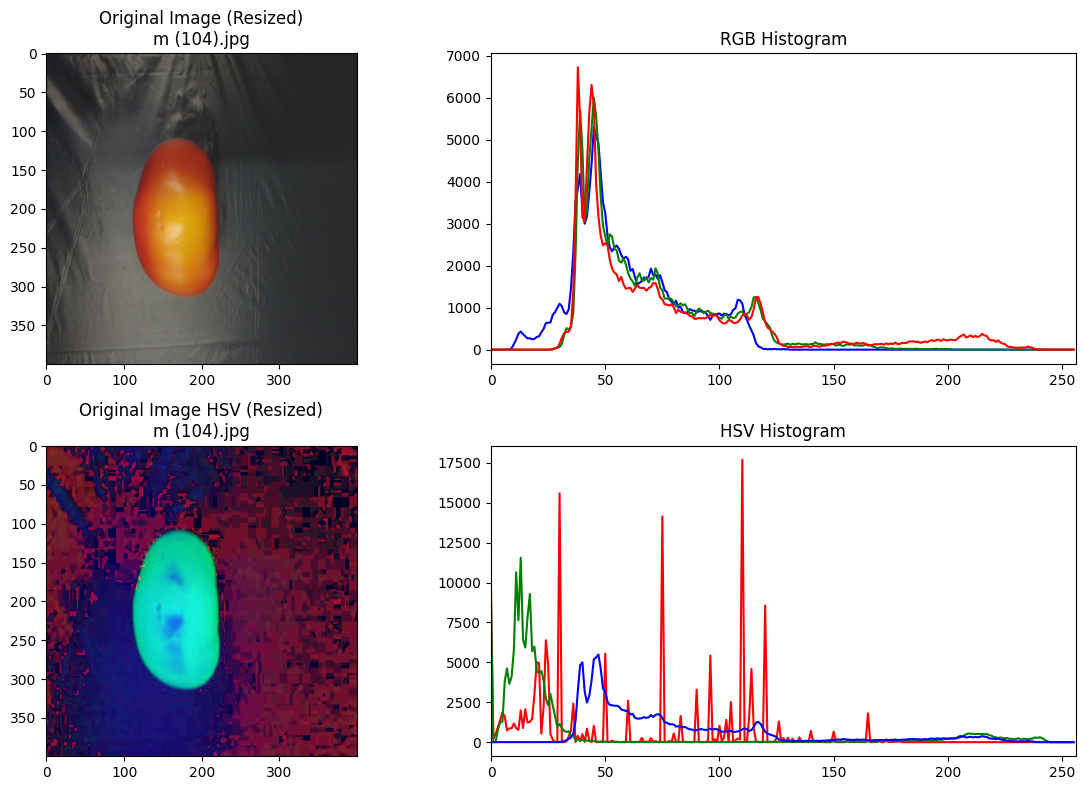

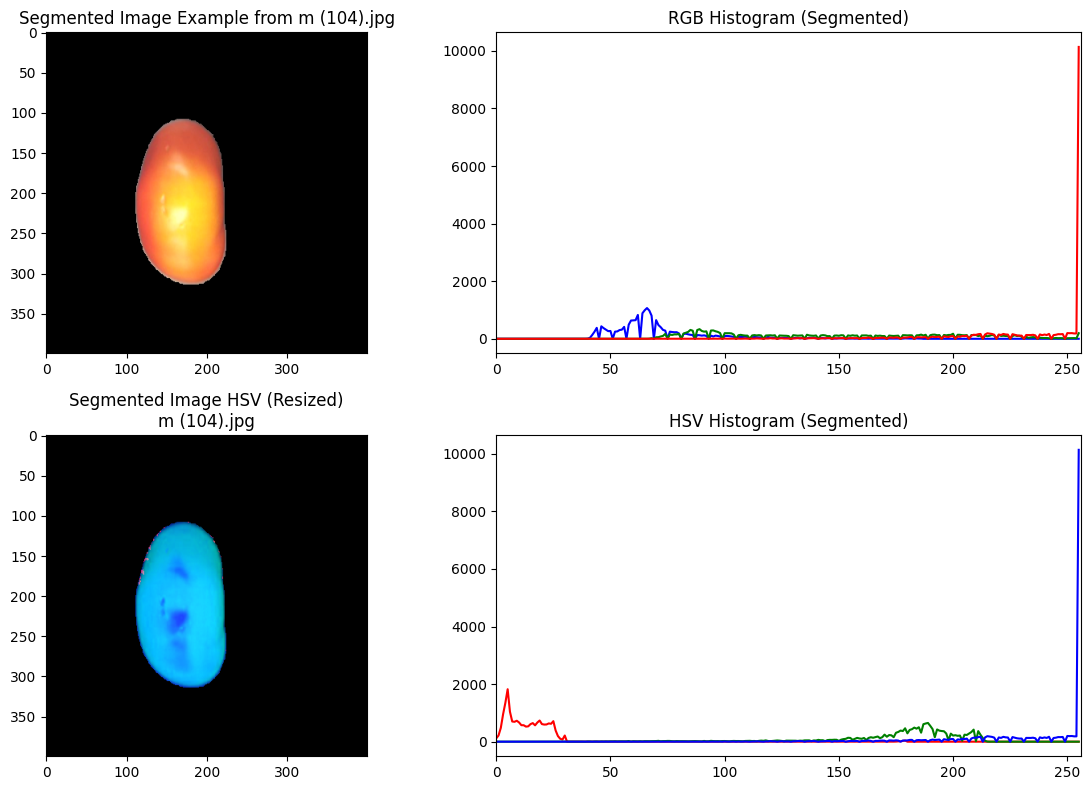

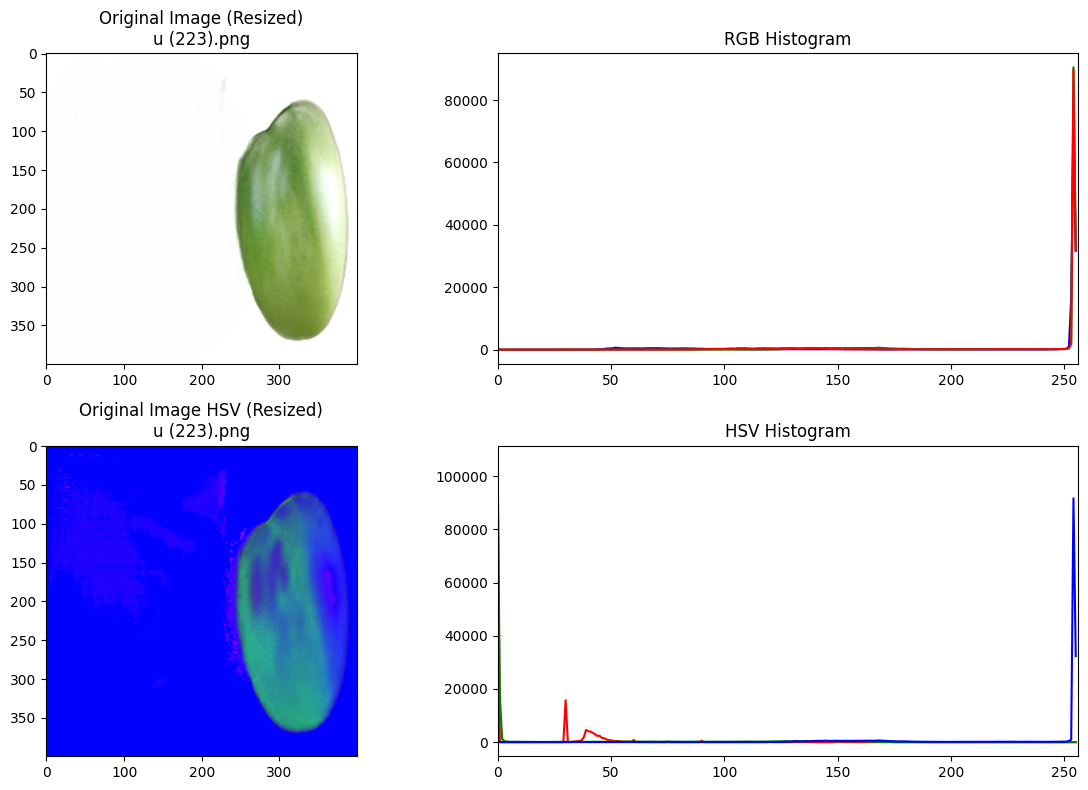

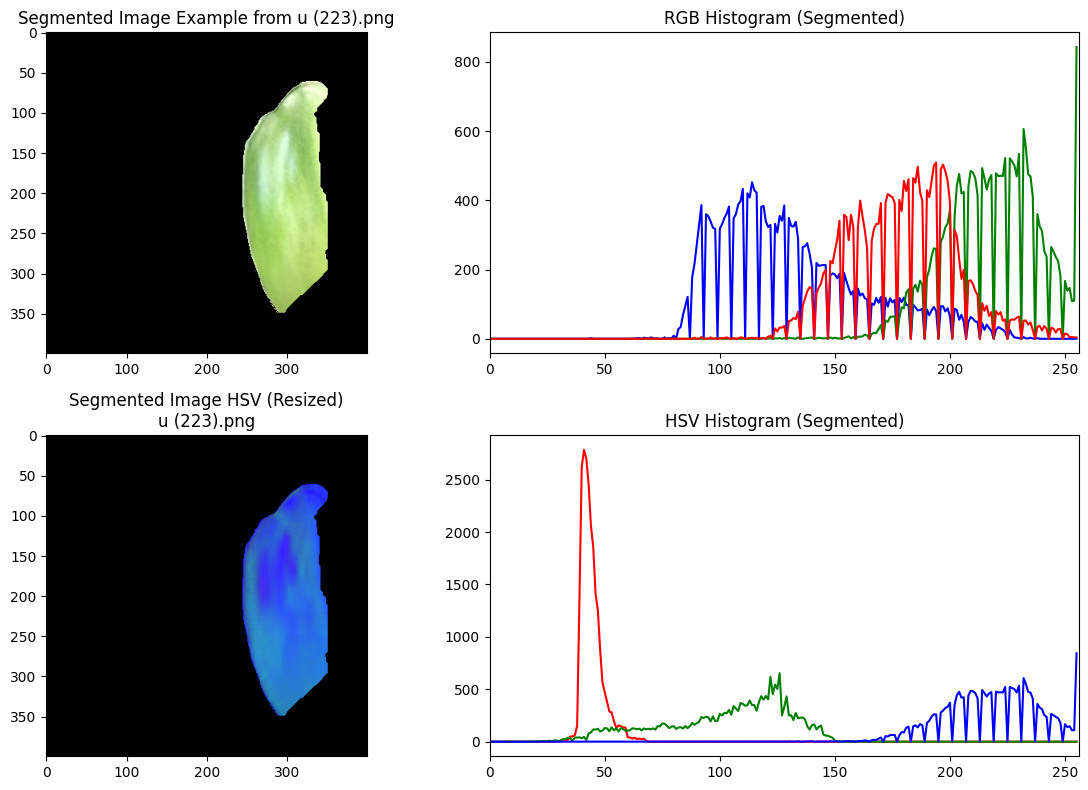

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Fungsi untuk membaca, meresize, dan menampilkan gambar bersama dengan histogram
def read_resize_and_display_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image from {image_path}")
        return None
    resized_image = cv2.resize(image, (400, 400))
    
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
    
    # Menampilkan gambar asli yang telah diresize dan histogram RGB
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image (Resized)\n{os.path.basename(image_path)}')
    
    plt.subplot(2, 2, 2)
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([resized_image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title('RGB Histogram')
    
    # Menampilkan gambar HSV yang telah diresize dan histogram HSV
    plt.subplot(2, 2, 3)
    plt.imshow(hsv_image)
    plt.title(f'Original Image HSV (Resized)\n{os.path.basename(image_path)}')
    
    plt.subplot(2, 2, 4)
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([hsv_image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title('HSV Histogram')
    
    plt.tight_layout()
    plt.show()
    
    return resized_image, hsv_image

# Fungsi untuk mengatur kontras dan kecerahan gambar
def adjust_contrast_brightness(image, alpha=1.0, beta=0):
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

# Fungsi untuk mengonversi gambar ke HSV dan melakukan segmentasi menggunakan GrabCut
def grabcut_segmentation(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    rect = (50, 50, 300, 300)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented_image = image * mask2[:, :, np.newaxis]
    
    # Menghapus tangkai dengan deteksi kontur
    contours, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 500:  # Filter berdasarkan area kontur
            cv2.drawContours(mask2, [cnt], -1, 0, -1)
    
    segmented_image = image * mask2[:, :, np.newaxis]
    
    return segmented_image, mask2

# Fungsi untuk menampilkan gambar dan histogram setelah segmentasi
def display_segmented_image_and_histogram(segmented_image, mask, image_name):
    hsv_segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2HSV)
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Segmented Image Example from {image_name}')
    
    plt.subplot(2, 2, 2)
    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([segmented_image], [i], mask, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title('RGB Histogram (Segmented)')
    
    plt.subplot(2, 2, 3)
    plt.imshow(hsv_segmented_image)
    plt.title(f'Segmented Image HSV (Resized)\n{image_name}')
    
    plt.subplot(2, 2, 4)
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([hsv_segmented_image], [i], mask, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title('HSV Histogram (Segmented)')
    
    plt.tight_layout()
    plt.show()

# Path ke folder dataset
dataset_path = 'C:/skripsi/coding_final/uji_dataset'
classes = ['matang', 'mengkal', 'mentah']

# Proses semua gambar dalam dataset dan tampilkan satu contoh dari setiap kelas
for cls in classes:
    cls_folder = os.path.join(dataset_path, cls)
    images = os.listdir(cls_folder)
    for i, image_name in enumerate(images):
        image_path = os.path.join(cls_folder, image_name)
        if i == 0:
            image, hsv_image = read_resize_and_display_image(image_path)
        else:
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip this image if it can't be read
            resized_image = cv2.resize(image, (400, 400))
            hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)
        
        if image is None:
            continue  # Skip this image if it can't be read
        
        resized_image = cv2.resize(image, (400, 400))
        
        # Adjust brightness and contrast
        adjusted_image = adjust_contrast_brightness(resized_image, alpha=1.2, beta=30)  # Example values
        segmented_image, mask = grabcut_segmentation(adjusted_image)
        
        if i == 0:
            display_segmented_image_and_histogram(segmented_image, mask, image_name)

        # Simpan hasil segmentasi untuk ekstraksi fitur
        output_path = os.path.join('C:/skripsi/coding_final/uji_segmented_images', cls)
        os.makedirs(output_path, exist_ok=True)
        segmented_image_path = os.path.join(output_path, image_name)
        cv2.imwrite(segmented_image_path, segmented_image)


In [5]:
import cv2
import numpy as np
import pandas as pd
import os

# Fungsi untuk ekstraksi fitur warna
def extract_color_features(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_image, (0, 0, 0), (180, 255, 255))  # Mask untuk menghilangkan background hitam
    hsv_values = hsv_image[mask > 0]
    
    mean_color = np.mean(hsv_values, axis=0)
    std_color = np.std(hsv_values, axis=0)
    
    return mean_color, std_color

# Path ke folder segmented images
segmented_images_path = 'C:/skripsi/coding_final/uji_segmented_images'
classes = ['matang', 'mengkal', 'mentah']

# List untuk menyimpan hasil ekstraksi fitur
features_list = []

# Proses semua gambar hasil segmentasi dan ekstrak fitur warna
for cls in classes:
    cls_folder = os.path.join(segmented_images_path, cls)
    images = os.listdir(cls_folder)
    for image_name in images:
        image_path = os.path.join(cls_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image from {image_path}")
            continue
        
        mean_color, std_color = extract_color_features(image)
        features_list.append([image_name, cls, *mean_color, *std_color])

# Buat DataFrame dari hasil ekstraksi fitur
columns = ['Image Name', 'Class', 'Mean_H', 'Mean_S', 'Mean_V', 'Std_H', 'Std_S', 'Std_V']
features_df = pd.DataFrame(features_list, columns=columns)

# Simpan hasil ekstraksi fitur ke CSV
output_csv_path = 'C:/skripsi/coding_final/uji_fitur_warna_tomat_HSV.csv'
features_df.to_csv(output_csv_path, index=False)

print(f"Fitur warna telah diekstraksi dan disimpan ke {output_csv_path}")


Fitur warna telah diekstraksi dan disimpan ke C:/skripsi/coding_final/uji_fitur_warna_tomat_HSV.csv


In [6]:
import cv2
import numpy as np
import pandas as pd
import os

# Fungsi untuk ekstraksi fitur warna RGB
def extract_rgb_features(image):
    mask = cv2.inRange(image, (0, 0, 0), (255, 255, 255))  # Mask untuk menghilangkan background hitam
    rgb_values = image[mask > 0]
    
    mean_color = np.mean(rgb_values, axis=0)
    std_color = np.std(rgb_values, axis=0)
    
    return mean_color, std_color

# Path ke folder segmented images
segmented_images_path = 'C:/skripsi/coding_final/uji_segmented_images'
classes = ['matang', 'mengkal', 'mentah']

# List untuk menyimpan hasil ekstraksi fitur
features_list = []

# Proses semua gambar hasil segmentasi dan ekstrak fitur warna
for cls in classes:
    cls_folder = os.path.join(segmented_images_path, cls)
    images = os.listdir(cls_folder)
    for image_name in images:
        image_path = os.path.join(cls_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image from {image_path}")
            continue
        
        mean_color, std_color = extract_rgb_features(image)
        features_list.append([image_name, cls, *mean_color, *std_color])

# Buat DataFrame dari hasil ekstraksi fitur
columns = ['Image Name', 'Class', 'Mean_R', 'Mean_G', 'Mean_B', 'Std_R', 'Std_G', 'Std_B']
features_df = pd.DataFrame(features_list, columns=columns)

# Simpan hasil ekstraksi fitur ke CSV
output_csv_path = 'C:/skripsi/coding_final/uji_fitur_warna_tomat_RGB.csv'
features_df.to_csv(output_csv_path, index=False)

print(f"Fitur warna RGB telah diekstraksi dan disimpan ke {output_csv_path}")


Fitur warna RGB telah diekstraksi dan disimpan ke C:/skripsi/coding_final/uji_fitur_warna_tomat_RGB.csv
